In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic_2d
from datetime import datetime

In [2]:
regions = pd.read_csv('regions.csv', sep=';')

In [3]:
%%time
month_data = pd.read_csv('yellow_tripdata_2016-05.csv')

Wall time: 46.3 s


In [4]:
month_data['tpep_pickup_datetime'] = pd.to_datetime(month_data['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
month_data['tpep_dropoff_datetime'] = pd.to_datetime(month_data['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

In [5]:
month_data['start_hour'] = month_data['tpep_pickup_datetime'].apply(lambda ts: datetime(
    ts.year, ts.month, ts.day, ts.hour))

In [6]:
long_min = -74.25559
long_max = -73.70001
lat_min = 40.49612
lat_max = 40.91553

In [7]:
month_data_free = month_data.drop(month_data[(month_data['trip_distance'] == 0.0)
                           | (month_data['passenger_count'] == 0)
                           | (month_data['tpep_pickup_datetime'] == month_data['tpep_dropoff_datetime'])
                           | (month_data['pickup_longitude'] <= long_min)
                           | (month_data['pickup_longitude'] >= long_max)
                           | (month_data['pickup_latitude'] <= lat_min)
                           | (month_data['pickup_latitude'] >= lat_max)].index, inplace=True)

In [8]:
binx = np.linspace(long_min, long_max, num=51)
biny = np.linspace(lat_min, lat_max, num=51)

In [9]:
ret = binned_statistic_2d(month_data['pickup_longitude'], 
                                month_data['pickup_latitude'], 
                                None, 'count', bins=[binx,biny], 
                                range=[[long_min, long_max], [lat_min, lat_max]],
                                expand_binnumbers=True)

In [10]:
region_ids = np.zeros(shape=(ret.binnumber[0].shape[0], 1))

In [19]:
for i in range(ret.binnumber[0].shape[0]):
        region_ids[i] = (ret.binnumber[0][i] - 1) * 50 + ret.binnumber[1][i]

In [20]:
month_data.insert(len(month_data.columns), column='region', value=region_ids)

In [21]:
month_data = month_data.loc[:, ['start_hour', 'region']]

In [37]:
month_data_sum = month_data.reset_index().groupby(["start_hour", "region"], 
                                                  as_index=False).count()

In [39]:
month_data_sum.head()

,start_hour,region,index
0,2016-05-01,1015.0,1
1,2016-05-01,1017.0,1
2,2016-05-01,1029.0,3
3,2016-05-01,1030.0,1
4,2016-05-01,1033.0,4


In [40]:
empty_regions_hours = pd.DataFrame()

In [41]:
date_rng = pd.date_range(start='05/01/2016', end='05/31/2016 23:00:00', freq='H')

In [42]:
%%time
df_empty = pd.DataFrame()
for i in range(1, 2501):
    df = pd.DataFrame(date_rng, columns=['start_hour'])
    df['region'] = i
    df['index'] = 0
    df_empty = pd.concat([df_empty, df])

Wall time: 42.8 s


In [43]:
df_empty.head()

,start_hour,region,index
0,2016-05-01 00:00:00,1,0
1,2016-05-01 01:00:00,1,0
2,2016-05-01 02:00:00,1,0
3,2016-05-01 03:00:00,1,0
4,2016-05-01 04:00:00,1,0


In [44]:
month_data_sum['region'] = (month_data_sum['region']).astype(np.int64)

In [ ]:
month_data_sum['index'] = (month_data_sum['index']).astype(np.int64)

In [52]:
month_data_sum.head()

,start_hour,region,index
0,2016-05-01,1015,1
1,2016-05-01,1017,1
2,2016-05-01,1029,3
3,2016-05-01,1030,1
4,2016-05-01,1033,4


In [46]:
month_data_sum = month_data_sum.sort_values(by=['start_hour', 'region'])

In [53]:
month_data_sum.head()

,start_hour,region,index
0,2016-05-01,1015,1
1,2016-05-01,1017,1
2,2016-05-01,1029,3
3,2016-05-01,1030,1
4,2016-05-01,1033,4


In [47]:
df_empty = df_empty.sort_values(by=['start_hour', 'region'])

In [54]:
df_empty.head()

,start_hour,region,index
0,2016-05-01,1,0
0,2016-05-01,2,0
0,2016-05-01,3,0
0,2016-05-01,4,0
0,2016-05-01,5,0


In [48]:
month_data_full = pd.merge_asof(df_empty, month_data_sum, on='start_hour', by=['start_hour', 'region'])

In [49]:
month_data_full.head()

,start_hour,region,index_x,index_y
0,2016-05-01,1,0,NaN
1,2016-05-01,2,0,NaN
2,2016-05-01,3,0,NaN
3,2016-05-01,4,0,NaN
4,2016-05-01,5,0,NaN


In [50]:
month_data_full['count'] = month_data_full.apply(lambda x: x['index_y'] if pd.notna(x['index_y']) else x['index_x'], axis=1)

In [51]:
month_data_full.head()

,start_hour,region,index_x,index_y,count
0,2016-05-01,1,0,NaN,0.0
1,2016-05-01,2,0,NaN,0.0
2,2016-05-01,3,0,NaN,0.0
3,2016-05-01,4,0,NaN,0.0
4,2016-05-01,5,0,NaN,0.0


In [280]:
month_data_full = month_data_full.drop(['index_y', 'index_x'], axis=1)

In [281]:
month_data_full

,start_hour,region,count
0,2016-05-01 00:00:00,1,0.0
1,2016-05-01 00:00:00,2,0.0
2,2016-05-01 00:00:00,3,0.0
3,2016-05-01 00:00:00,4,0.0
4,2016-05-01 00:00:00,5,0.0
5,2016-05-01 00:00:00,6,0.0
6,2016-05-01 00:00:00,7,0.0
7,2016-05-01 00:00:00,8,0.0
8,2016-05-01 00:00:00,9,0.0
9,2016-05-01 00:00:00,10,0.0


In [282]:
month_data_full.head()

,start_hour,region,count
0,2016-05-01,1,0.0
1,2016-05-01,2,0.0
2,2016-05-01,3,0.0
3,2016-05-01,4,0.0
4,2016-05-01,5,0.0


In [283]:
esb_lat = 40.748817
esb_lon = -73.985428

In [284]:
esb_region = int(regions[(esb_lat >= regions['south']) &
                     (esb_lat <= regions['north']) &
                     (esb_lon >= regions['west']) &
                     (esb_lon <= regions['east'])]['region'])

In [285]:
X = month_data_full[month_data_full['region'] == esb_region]['start_hour']
Y = month_data_full[month_data_full['region'] == esb_region]['count']

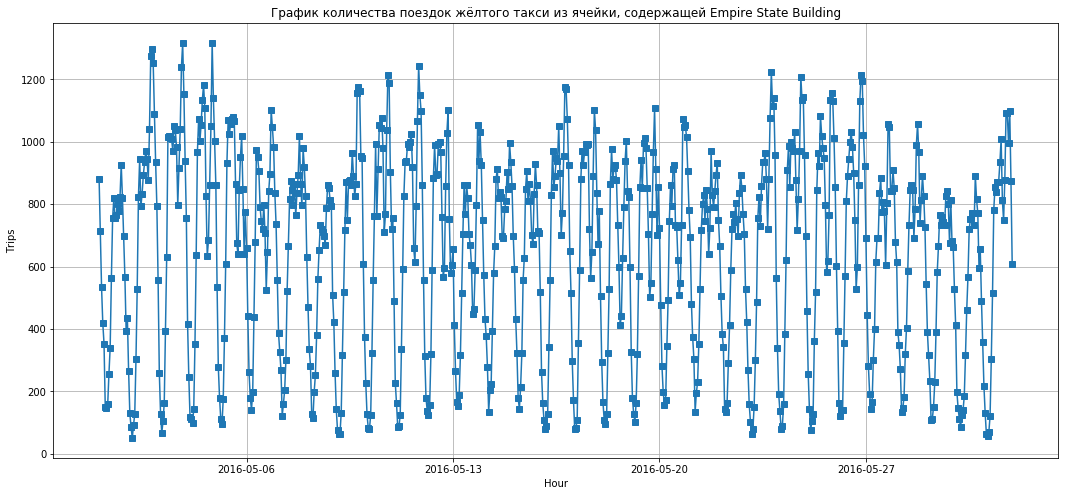

In [286]:
plt.figure(figsize(18,8))
plt.plot(X, Y, marker='s');
plt.xlabel('Hour')
plt.ylabel('Trips')
plt.grid()
plt.title(u'График количества поездок жёлтого такси из ячейки, содержащей Empire State Building')
pylab.show()

## Количество пар час-ячейка, для которых в мае 2016 не было совершено ни одной поездки

In [287]:
month_data_full[month_data_full['count'] == 0.].shape[0]

1718238